# NBA Data :: Preprocessing Script

This notebook will take our data, a series of NBA simple and advanced box scores from 2004-2024, and create a CSV of data from 2014-2024. This should remove a lot of missing data or incorrectly imputed values.

Notes from Meeting on 3/4/2025:

- We need to be *confirming* after each step. When we pull the data, use a head() statement. When we drop columns or rows, confirm that they are dropped.

In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'

file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')

df = df[df['season'].str[:4].astype(int) > 2013] # Remove old seasons (this was causing issues)

print(f'The seasons are now: {df.season.unique()}') 

df = df.select_dtypes('number') # Filter for only numbers

df.head()

The seasons are now: ['2014-15' '2015-16' '2016-17' '2017-18' '2018-19' '2019-20' '2020-21'
 '2021-22' '2022-23' '2023-24']


,game_id,team_id,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
13932,41400406,1610612739,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,...,0.316,0.390,17.0,28.0,0.607,105.0,1,0,1,0
13933,41400405,1610612744,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,...,0.548,0.480,11.0,22.0,0.500,91.0,1,1,1,0
13934,41400404,1610612739,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,...,0.238,0.330,9.0,14.0,0.643,103.0,1,0,1,0
13935,41400403,1610612739,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,...,0.467,0.461,12.0,24.0,0.500,91.0,1,1,1,0
13936,41400402,1610612744,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,...,0.404,0.398,7.0,19.0,0.368,95.0,1,0,1,0


# 1. Removing Missing Data

First we can check the missing data in our DataFrame.

In [70]:
def pct_missing(data):
    x = data.isnull().sum().divide(len(data)).sort_values(ascending=False)
    return pd.DataFrame(x, columns=['pct. missing'])

pct_missing(df)

,pct. missing
turnover_ratio,0.000765
estimated_team_turnover_percentage,0.000765
defensive_rating,0.000765
estimated_net_rating,0.000765
net_rating,0.000765
...,...
is_playoff_game,0.000000
game_id,0.000000
is_home_team,0.000000
team_id,0.000000


In [71]:
print(f'Initially, there are {df.isna().sum().sum()} Missing Values')
print(f'There are also {df.points.isna().sum()} Missing values in our dependent variable.')
cleaned = df.dropna()
print('Dropped Values with pd.DataFrame.dropna()...')
print(f'Now after dropping, we have {cleaned.isna().sum().sum()} missing values')

Initially, there are 730 Missing Values
There are also 11 Missing values in our dependent variable.
Dropped Values with pd.DataFrame.dropna()...
Now after dropping, we have 0 missing values


## 2. Removing Multicollinear and Low-Variance Features

Now we will add the lecture content from 2/27/25 going over how to remove multicollinear features and low-variance features. We will be removing any features with a correlation of `0.7` or above, and a variance of `0.1` or lower.

In [72]:
'''
removeHighCorrFeatures removes highly correlated independent features. This function takes in a DataFrame, a String of the feature name,
and the threshold, which is the correlation between features where any correlations above this level will be removed.

returns a tuple (new_data, to_drop) that contains the new DataFrame and the dropped data to be checked.
'''
def removeHighCorrFeatures(data: pd.DataFrame, dep_var: str, thresh=.7):
    from dython.nominal import associations

    # Compute a corr_matrix and obtain abs value of the corr. Recall corrs are in the range [-1,1]
    corr_matrix = associations(dataset=data.drop(dep_var, axis=1), compute_only=True)['corr'].abs()

    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # for loop to drop all features where abs(correlation) > threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column]>thresh)]

    print(f'We will be dropping {len(to_drop)} features due to Multicollinearity. These dropped features will be returned as part of the returned tuple.')

    # assign to df
    new_data = data.drop(to_drop, axis=1)

    return new_data, to_drop

In [73]:
'''
remove_nzv_features removes features in the DataFrame with a variance below the parameter threshold. 
This is done by creating a mask using the sklearn VarianceThreshold function.

returns a tuple of the dataframe with the selected features (retained_df) and a dataframe of the dropped features (dropped_df)
'''
def remove_nzv_features(df:pd.DataFrame, threshold=.1): 
    from sklearn.feature_selection import VarianceThreshold

    vThreshold = VarianceThreshold(threshold)
    vThreshold.fit_transform(df)

    # Get boolean mask for selected columns
    mask = vThreshold.get_support()
    
    # Select columns to keep and drop
    selected_columns = df.columns[mask]
    dropped_columns = df.columns[~mask]
    
    # Create DataFrames for retained and removed features
    retained_df = df[selected_columns]
    dropped_df = df[dropped_columns]

    return retained_df, dropped_df


In [74]:
def scale_features(df:pd.DataFrame):
    from sklearn.preprocessing import StandardScaler

    df_std = StandardScaler().fit_transform(df)
    cleaned = pd.DataFrame(df_std, columns=df.columns)
    orig_df = df

    return cleaned, orig_df

In [75]:
def my_corrplot(df, dep_var):
    import seaborn as sns
    from dython.nominal import associations

    # create a correlation matrix of all predictor variables using 'associations'
    corr_matrix = associations(dataset=df.drop(dep_var, axis=1), compute_only=True)['corr']

    # Mask upper triangle of the corr heatmap ???
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot
    plt.figure(figsize=(44,44))
    sns.heatmap(corr_matrix, annot=True, mask=mask_upper, fmt='.2f', vmin=-1, vmax=1)
    plt.show()

In [76]:
'''This compares the scaled summary stats to the unscaled summary stats'''
def compare_scaled_unscaled(unscaled_df: pd.DataFrame, scaled_df: pd.DataFrame):
    comparison = pd.concat([
        unscaled_df.describe().T[['mean', 'std', 'min', 'max']].rename(columns=lambda x: f"unscaled_{x}"),
        scaled_df.describe().T[['mean', 'std', 'min', 'max']].rename(columns=lambda x: f"scaled_{x}")
    ], axis=1)
    
    return comparison


Now we have functions we can call on the dataframe to remove all features with high correlation, low variance, and to scale the features for the model.

In [77]:
df_no_multicollinearity = removeHighCorrFeatures(cleaned, 'points')
print(f'The features removed for high correlation are:\n{df_no_multicollinearity[1]}')
df_no_nzv = remove_nzv_features(df_no_multicollinearity[0])
print(f'The features removed for near-zero variance are:\n{df_no_nzv[1]}')
df_scaled = scale_features(df_no_nzv[0])
print(f'Here is what changed after scaling the DataFrame:')
print(compare_scaled_unscaled(df_scaled[0], df_scaled[1]))

df_scaled = df_scaled[0]

We will be dropping 37 features due to Multicollinearity. These dropped features will be returned as part of the returned tuple.
The features removed for high correlation are:
['field_goals_percentage', 'three_pointers_attempted', 'free_throws_attempted', 'rebounds_total', 'estimated_offensive_rating', 'offensive_rating', 'defensive_rating', 'estimated_net_rating', 'net_rating', 'assist_to_turnover', 'assist_ratio', 'rebound_percentage', 'estimated_team_turnover_percentage', 'turnover_ratio', 'effective_field_goal_percentage', 'true_shooting_percentage', 'pace_per40', 'possessions', 'p_i_e', 'rebound_chances_defensive', 'rebound_chances_total', 'touches', 'passes', 'assists', 'contested_field_goals_made', 'contested_field_goals_attempted', 'contested_field_goal_percentage', 'uncontested_field_goals_made', 'uncontested_field_goals_attempted', 'uncontested_field_goals_percentage', 'field_goal_percentage', 'defended_at_rim_field_goals_made', 'defended_at_rim_field_goals_attempted', 'defen

Now the Data is prepared. We can drop the id's for the model.

In [78]:
to_drop = ['game_id','team_id', 'is_home_team']
df_dropped_ids = df_scaled.drop(to_drop, axis=1)

df_dropped_ids.head()

,field_goals_made,field_goals_attempted,three_pointers_made,free_throws_made,rebounds_offensive,rebounds_defensive,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_defensive_rating,estimated_pace,pace,distance,rebound_chances_offensive,secondary_assists,free_throw_assists,is_regular_game
0,-1.435856,-0.623002,-1.210848,1.573969,1.518257,1.139879,-1.579043,0.856545,0.594897,1.309824,-0.837497,-0.544742,-0.183709,0.114135,0.163795,0.211644,1.973250,-0.414480,-0.477574,-2.627279
1,-0.713784,-1.523045,0.246879,0.412374,0.197895,-0.310934,-0.227159,-1.138036,0.594897,1.084791,-0.323559,0.884189,-0.909108,-0.932090,-1.176597,0.213856,2.354149,0.582352,-0.477574,-2.627279
2,-1.977411,0.148463,-1.696757,0.412374,1.518257,-0.129582,-1.917015,-0.739120,-1.149597,-0.265408,-1.938792,-1.429318,0.591717,-1.556968,-0.985112,0.085591,1.878025,0.582352,0.194466,-2.627279
3,-0.894302,-1.394467,-0.481984,-0.085452,-1.122467,0.595824,0.448784,1.255462,0.096470,-0.940508,-0.910916,0.339835,-0.650633,-1.142763,-0.793628,-0.016135,0.449653,-0.912896,-1.149614,-2.627279
4,-1.255338,-0.494425,-0.724939,0.246432,-0.066177,0.233121,1.124726,0.856545,1.093324,2.434990,-1.131176,-0.136476,-1.801265,-0.642860,-0.577888,0.390772,-0.121696,-1.411312,2.210584,-2.627279


Now we can plot the correlation matrix of the cleaned dataset

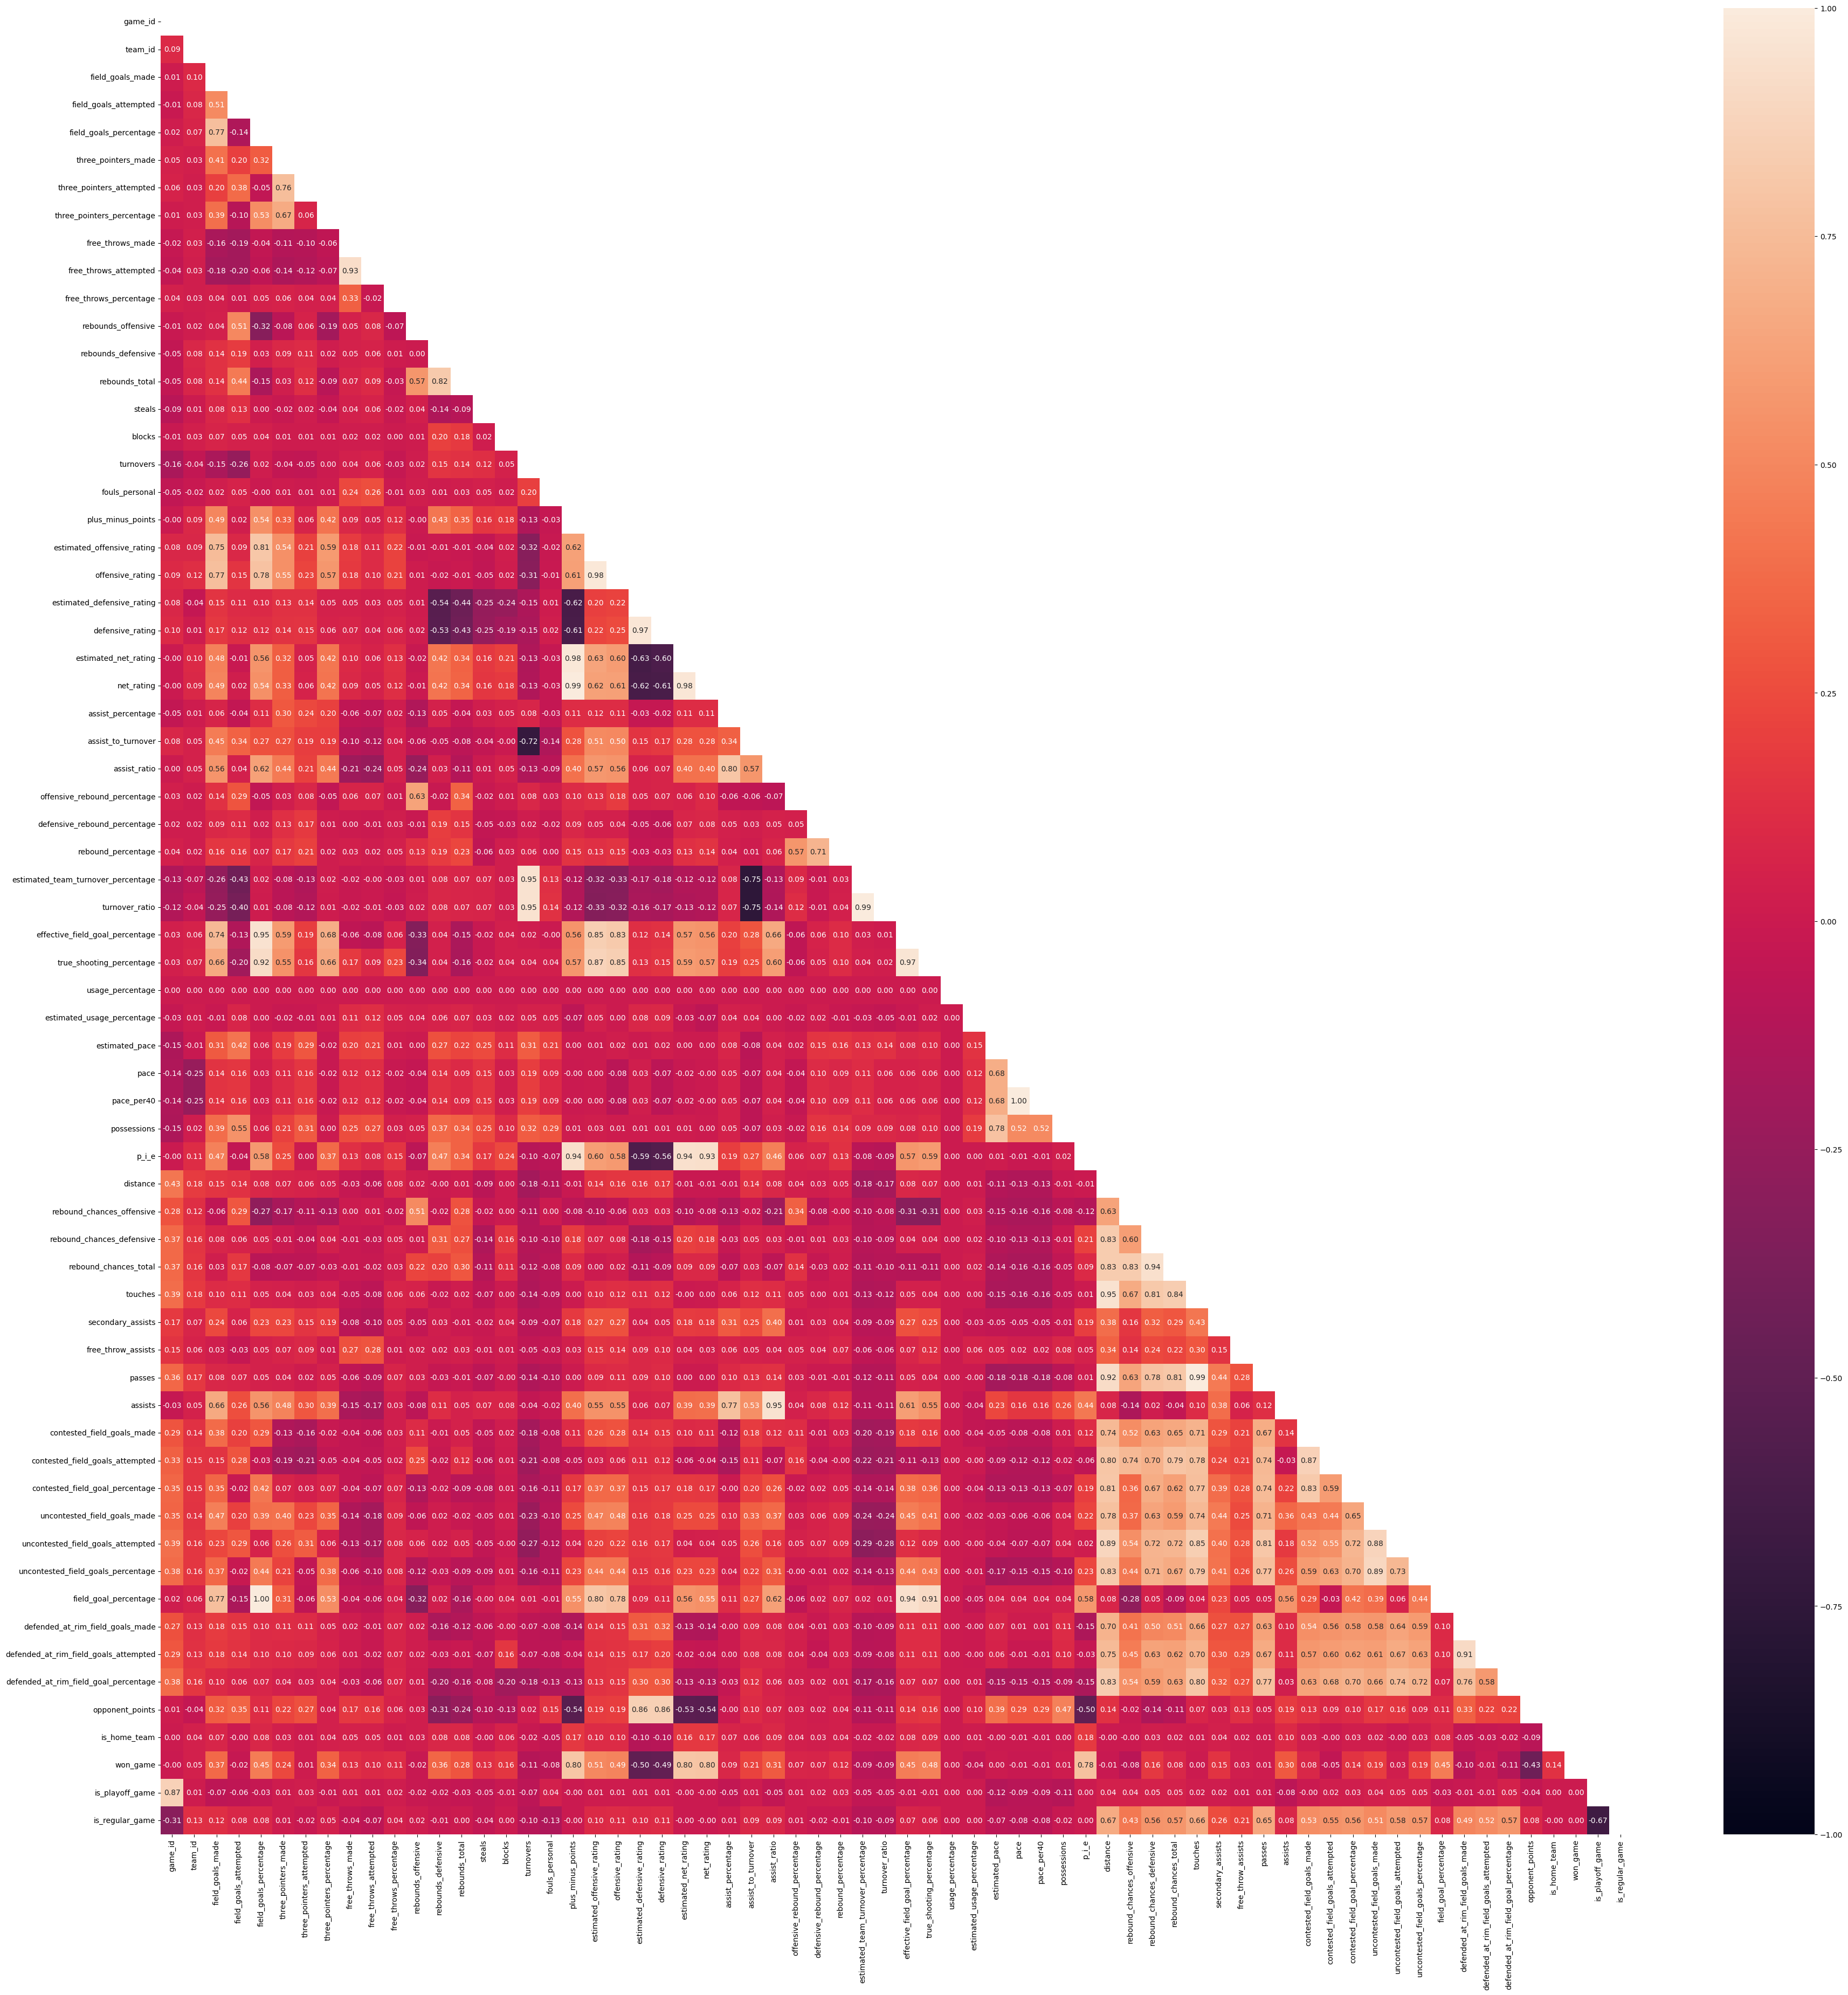

In [79]:
my_corrplot(cleaned, 'points')

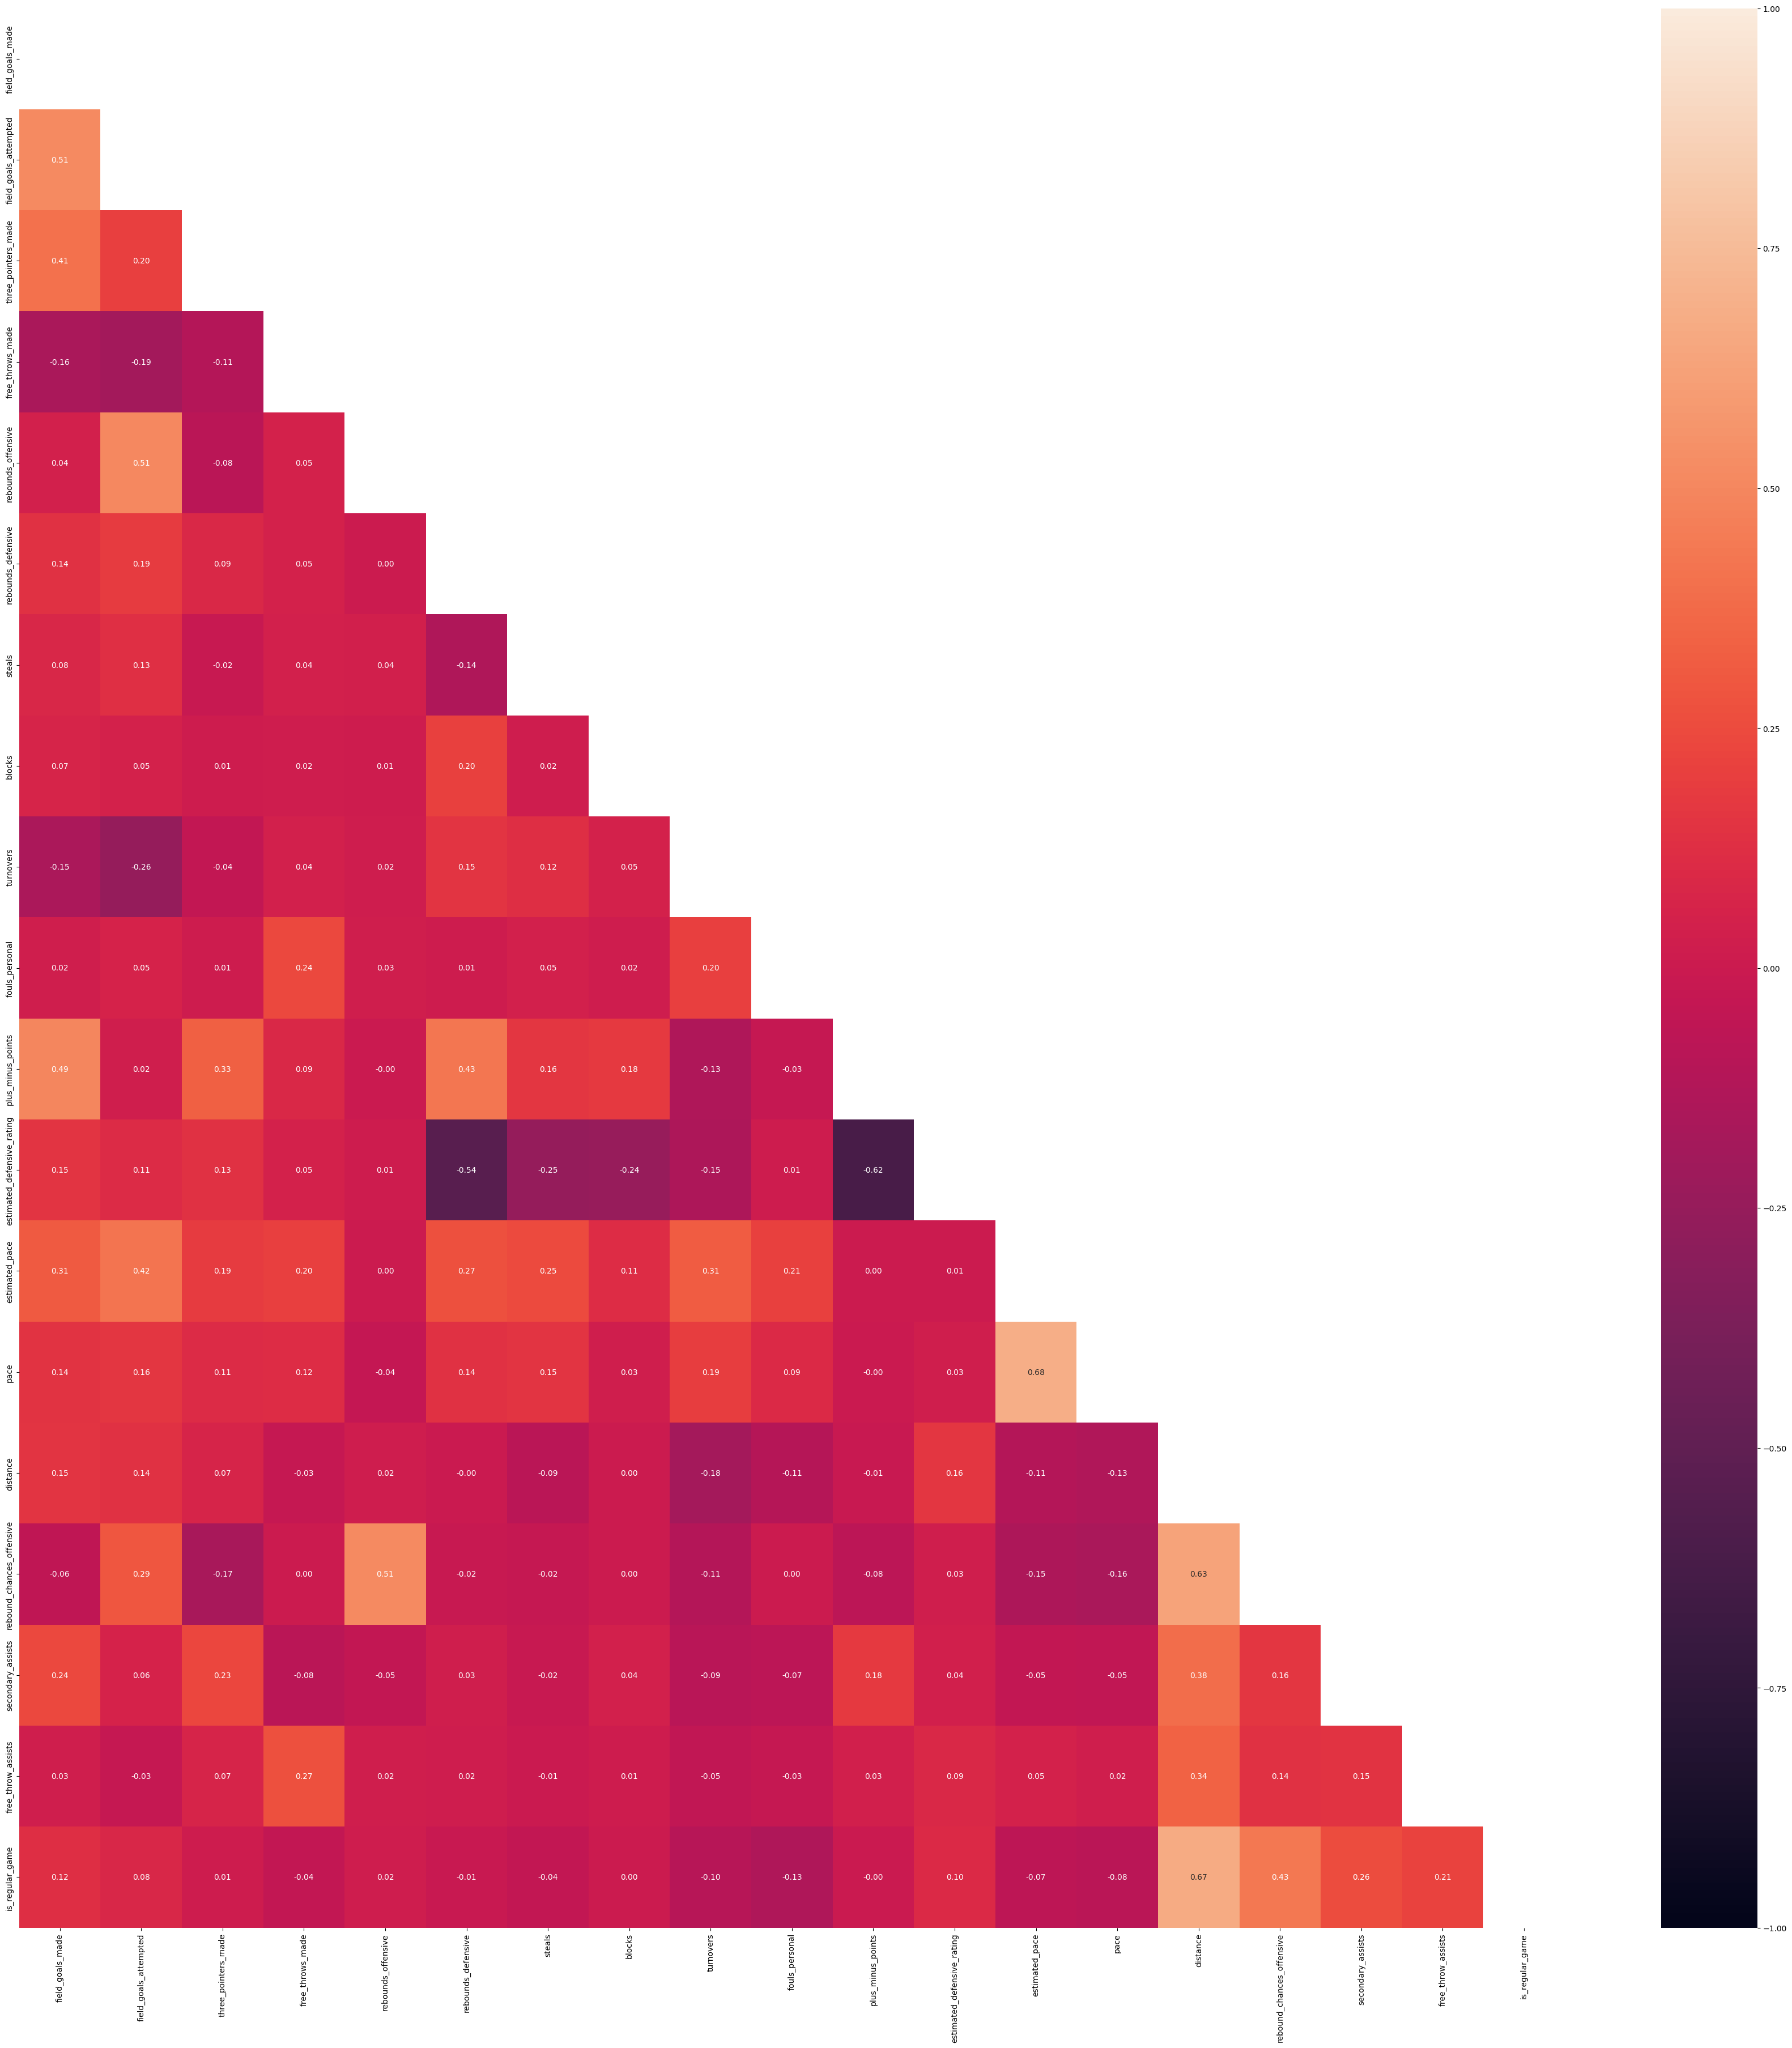

In [80]:
my_corrplot(df_dropped_ids, 'points')

Examine this one, any multicollinearity, drop variable with the lowest variance.

## 3. MLR Model

We will now create the Multiple Linear Regression Model to check against John's work.

In [81]:
from sklearn.model_selection import train_test_split

X = df_dropped_ids.loc[:, df_dropped_ids.columns != 'points']
y = df_dropped_ids.loc[:, df_dropped_ids.columns == 'points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2142)

In [82]:
import statsmodels.api as sm

train_X = sm.add_constant(X_train)

model = sm.OLS(y_train, train_X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.201e+30
Date:                Tue, 04 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:41:20   Log-Likelihood:             6.5796e+05
No. Observations:               21937   AIC:                        -1.316e+06
Df Residuals:                   21917   BIC:                        -1.316e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.166e-15   1.54e-16      7.570      0.000    8.64e-16    1.47e-15
field_goals_made               0.8134   5.75e-16   1.41e+15      0.000       0.813       0.813
field_goals_attempted       6.407e-16   4.37e-16      1.467      0.142   -2.15e-16     1.5e-15
three_pointers_made            0.3022   2.67e-16   1.13e+15      0.000       0.302       0.302
free_throws_made               0.4424   2.75e-16   1.61e+15      0.000       0.442       0.442
rebounds_offensive         -5.268e-17   2.87e-16     -0.184      0.854   -6.15e-16     5.1e-16
rebounds_defensive         -5.263e-16   2.43e-16     -2.162      0.031      -1e-15   -4.92e-17
steals                     -2.627e-16   1.95e-16     -1.345      0.179   -6.45e-16     1.2e-16
blocks                      -1.33e-17   1.63e-16     -0.082      0.935   -3.32e-16    3.05e-16
turnovers                   5.281e-16   2.65e-16      1.992      0.046    8.35e-18    1.05e-15
fouls_personal              1.946e-17    1.7e-16      0.114      0.909   -3.14e-16    3.53e-16
plus_minus_points           1.282e-15   7.35e-16      1.744      0.081   -1.58e-16    2.72e-15
estimated_defensive_rating  4.386e-16   6.18e-16      0.710      0.478   -7.73e-16    1.65e-15
estimated_pace             -1.381e-17    3.5e-16     -0.040      0.968   -6.99e-16    6.71e-16
pace                        1.942e-18   2.41e-16      0.008      0.994    -4.7e-16    4.74e-16
distance                   -7.033e-16   2.99e-16     -2.353      0.019   -1.29e-15   -1.17e-16
rebound_chances_offensive  -2.698e-16   2.87e-16     -0.941      0.347   -8.32e-16    2.92e-16
secondary_assists          -6.037e-16   1.75e-16     -3.444      0.001   -9.47e-16    -2.6e-16
free_throw_assists          5.621e-16   1.75e-16      3.207      0.001    2.19e-16    9.06e-16
is_regular_game            -8.641e-18   2.08e-16     -0.041      0.967   -4.17e-16       4e-16
==============================================================================
Omnibus:                     1025.987   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3413.797
Skew:                           0.126   Prob(JB):                         0.00
Kurtosis:                       4.916   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.b. Model Prediction:

In [83]:
test_x = sm.add_constant(X_test)

pred_train = model.predict(train_X)
pred_test = model.predict(test_x)

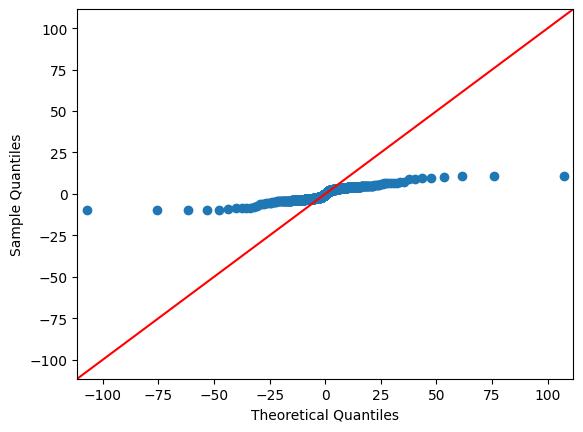

In [84]:
import scipy.stats as stats

res = model.resid
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

In [85]:
from dmba import regressionSummary

print('Training Data')
regressionSummary(y_train, pred_train)
print('Testing Data')
regressionSummary(y_test, pred_test)

Training Data

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.0000
            Mean Absolute Error (MAE) : 0.0000
          Mean Percentage Error (MPE) : 0.0000
Mean Absolute Percentage Error (MAPE) : 0.0000
Testing Data

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.0000
            Mean Absolute Error (MAE) : 0.0000
          Mean Percentage Error (MPE) : 0.0000
Mean Absolute Percentage Error (MAPE) : 0.0000


In [86]:
df.head()

,game_id,team_id,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
13932,41400406,1610612739,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,...,0.316,0.390,17.0,28.0,0.607,105.0,1,0,1,0
13933,41400405,1610612744,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,...,0.548,0.480,11.0,22.0,0.500,91.0,1,1,1,0
13934,41400404,1610612739,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,...,0.238,0.330,9.0,14.0,0.643,103.0,1,0,1,0
13935,41400403,1610612739,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,...,0.467,0.461,12.0,24.0,0.500,91.0,1,1,1,0
13936,41400402,1610612744,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,...,0.404,0.398,7.0,19.0,0.368,95.0,1,0,1,0


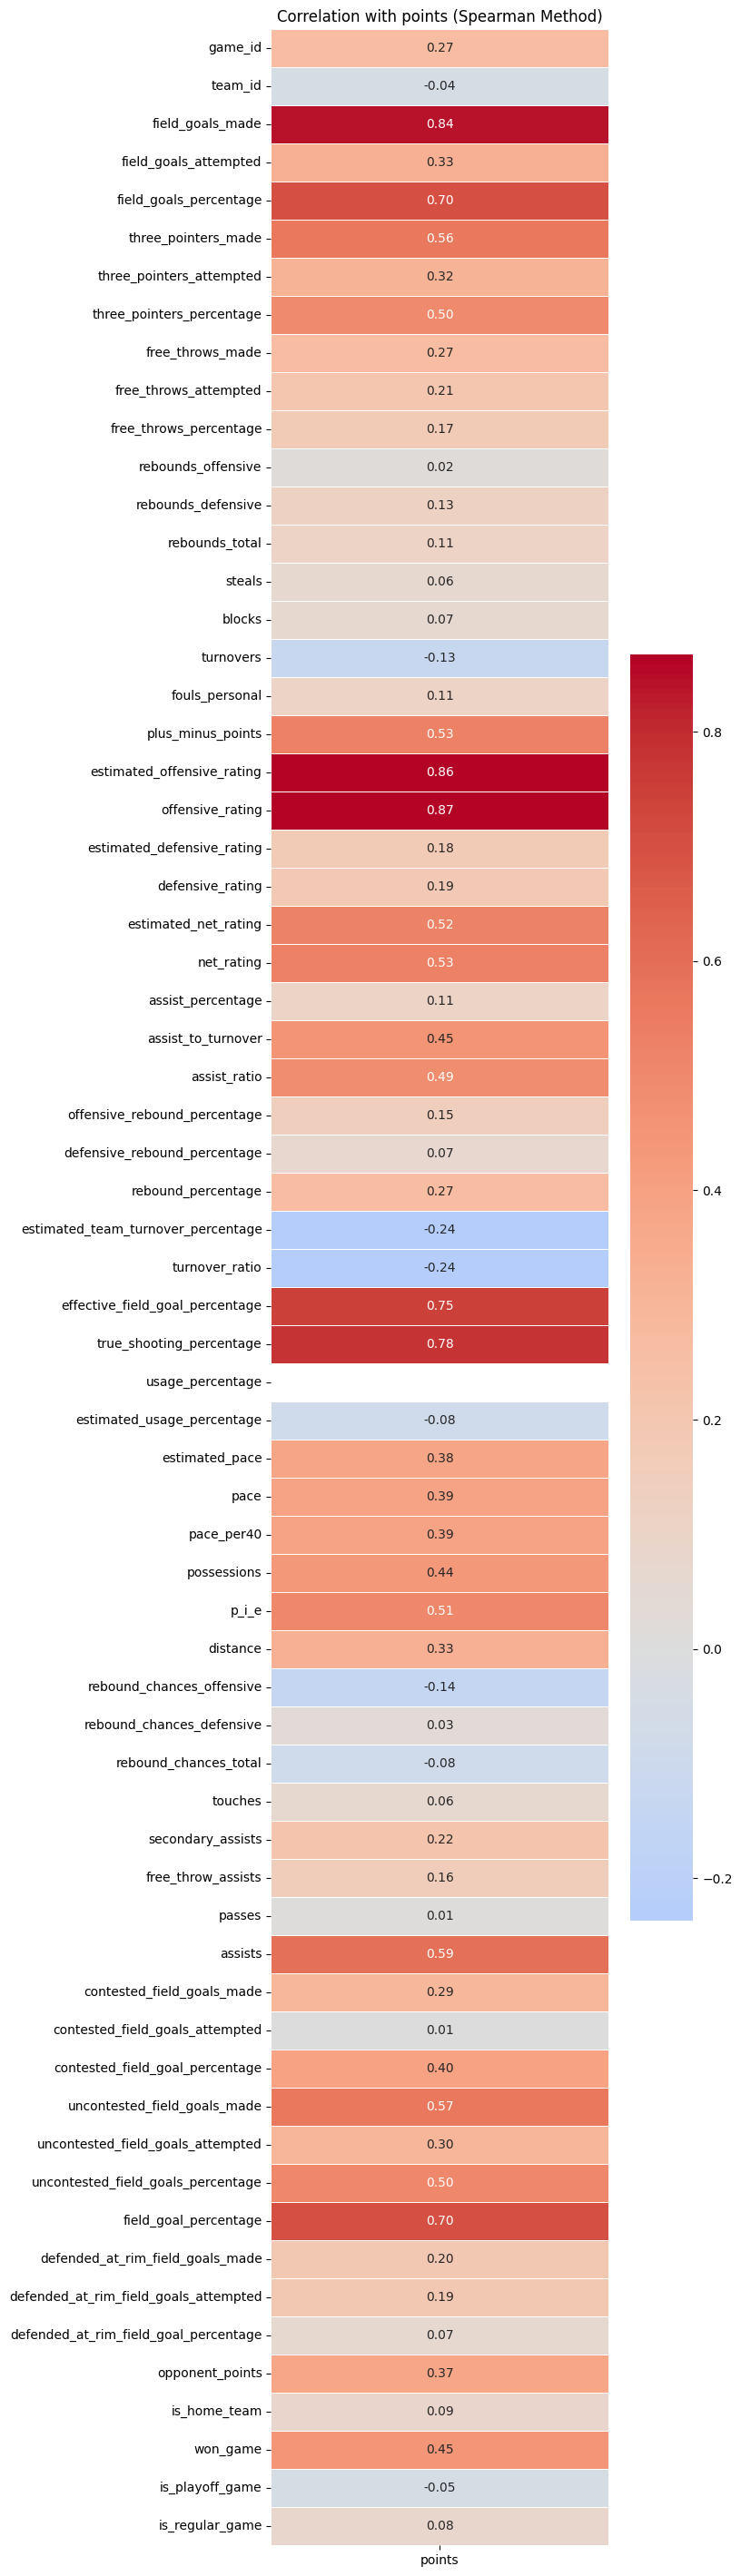

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_target_correlation_heatmap(df: pd.DataFrame, target_col: str, method: str = "pearson"):
    """
    Plots a heatmap showing the correlation between the dependent variable (target_col)
    and all independent variables in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The dataset containing features and target variable.
    - target_col (str): The name of the dependent (target) variable.
    - method (str): Correlation method ("pearson", "spearman", "kendall"). Default is "pearson".
    
    Returns:
    - Displays a heatmap of correlations.
    """
    if target_col not in df.columns:
        raise ValueError(f"Column '{target_col}' not found in DataFrame.")

    # Compute correlation
    corr_matrix = df.corr(method=method)
    
    # Select only correlations with the target variable
    target_corr = corr_matrix[[target_col]].drop(index=target_col)
    
    # Plot heatmap
    plt.figure(figsize=(6, len(target_corr) * 0.5 + 3))  # Adjust height based on number of features
    sns.heatmap(target_corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5, fmt=".2f")
    plt.title(f"Correlation with {target_col} ({method.capitalize()} Method)")
    plt.show()

# Example usage
plot_target_correlation_heatmap(df, target_col="points", method="spearman")

Do a correlation heatmap of true_shooting_percentage, field_goal_percentage, effective_field_goal_percentage, offensive_rating, estimated_offensive_rating, field_goal_percentage, field_goals_made

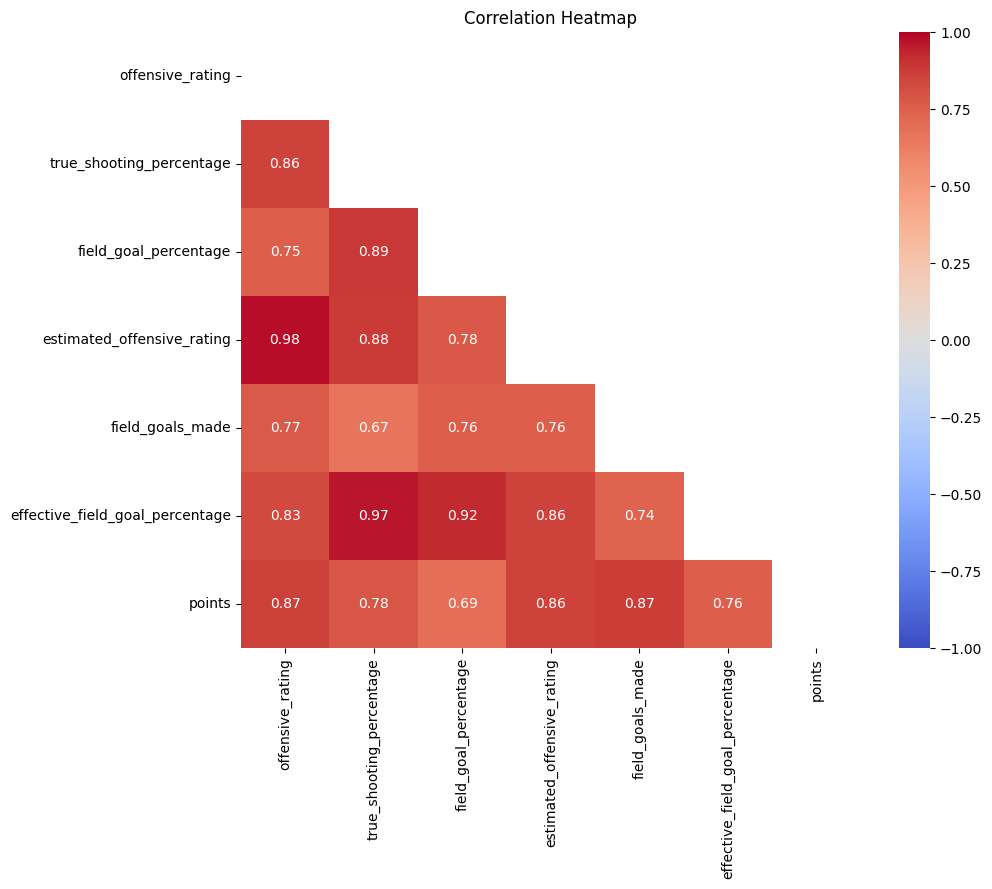

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

def my_corrplot2(df: pd.DataFrame, dep_var: str):
    """
    Generates a correlation heatmap using the `associations` function from dython.

    Parameters:
    - df (pd.DataFrame): The dataset.
    - dep_var (str): The dependent variable.

    Returns:
    - Displays a heatmap of correlations.
    """
    selected_features = [
        "true_shooting_percentage",
        "field_goal_percentage",
        "effective_field_goal_percentage",
        "offensive_rating",
        "estimated_offensive_rating",
        "field_goal_percentage",  # Duplicate, can be removed
        "field_goals_made"
    ]

    # Ensure selected features + dependent variable exist in df
    selected_features = list(set(selected_features))  # Remove duplicates
    selected_features.append(dep_var)
    selected_features = [col for col in selected_features if col in df.columns]

    # Compute associations
    corr_matrix = associations(dataset=df[selected_features], compute_only=True)["corr"]

    # Mask upper triangle of the heatmap
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot heatmap
    plt.figure(figsize=(10, 8))  # Adjusted size for clarity
    sns.heatmap(corr_matrix, annot=True, mask=mask_upper, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")
    plt.show()

# Example usage:
my_corrplot2(df, dep_var="points")


Take out the 